# THE MARCENKO–PASTUR (MP) PDF


Assymptotic distribution of eigenvalues of a specific random matrix. https://en.wikipedia.org/wiki/Marchenko%E2%80%93Pastur_distribution

 The code above shows how well MP pdf explains eigenvalues of random matrix x

In [109]:
import matplotlib.pyplot as plt
import numpy as np,pandas as pd

from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize

In [25]:
def mpPDF(var,q,pts):
    # Marcenko-Pastur pdf
    # q=T/N (>1)
    # pts - amount of points
    eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
    eVal=np.linspace(eMin,eMax,pts)
    pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
    pdf=pd.Series(pdf,index=eVal)
    return pdf

In [26]:

def getPCA(matrix):
# Get eVal,eVec from a !!!Hermitian matrix (cov matrix is a hermitian matrix)
    eVal,eVec=np.linalg.eigh(matrix) 
    indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
    eVal,eVec=eVal[indices],eVec[:,indices]
    eVal=np.diagflat(eVal)
    return eVal,eVec


def fitKDE(obs,bWidth=.25,kernel='gaussian',x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape)==1:obs=obs.reshape(-1,1)
    kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
    if x is None:x=np.unique(obs).reshape(-1,1)
    if len(x.shape)==1:x=x.reshape(-1,1)
    logProb=kde.score_samples(x) # log(density)
    pdf=pd.Series(np.exp(logProb),index=x.flatten())
    return pdf

In [102]:
np.random.seed(32)

N = 1000  # num of vars
T = 10000 # num of observations
x = np.random.normal(0, 1, size = (T, N))
cor = np.corrcoef(x, rowvar=0) # cor.shape = (1000,1000). If rowvar=1 - row represents a var, with observations in the columns.
eVal0 , eVec0 = getPCA( cor ) 
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.06) #empirical pdf


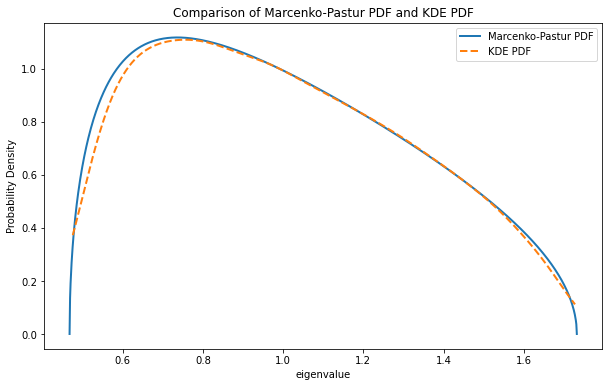

In [108]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur PDF', linewidth=2)
plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

# MP for not perfectly random function

The code above shows how MP works with not perfectly random function.

_____
Look at RANDOM MATRIX THEORY AND FINANCIAL CORRELATIONS LAURENT LALOUX, PIERRE CIZEAU and MARC POTTERS to understand the approach

In [132]:
def getRndCov(nCols, nFacts): #nFacts - contains signal out of nCols
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T) #random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols)) #full rank cov
    return cov

def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr
    
def corr2cov(corr, std):
    cov = corr * np.outer(std, std)
    return cov     
    
#snippet 2.4 - fitting the marcenko-pastur pdf - find variance
#Fit error
def errPDFs(var, eVal, q, bWidth, pts=1000):
    var = var[0]
    pdf0 = mpPDF(var, q, pts) #theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values) #empirical pdf
    sse = np.sum((pdf1-pdf0)**2)
    print("sse:"+str(sse))
    return sse 
    
# find max random eVal by fitting Marcenko's dist
# and return variance
def findMaxEval(eVal, q, bWidth):
    out = minimize(lambda *x: errPDFs(*x), x0=np.array(0.5), args=(eVal, q, bWidth), bounds=((1E-5, 1-1E-5),))
    print("found errPDFs"+str(out['x'][0]))
    if out['success']: var = out['x'][0]
    else: var=1
    eMax = var*(1+(1./q)**.5)**2
    return eMax, var

In [131]:
cov2corr(np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0))

array([[ 1.00000000e+00,  2.58151791e-03,  4.40751267e-03, ...,
        -1.82211385e-02,  4.17869961e-03,  7.67113938e-03],
       [ 2.58151791e-03,  1.00000000e+00, -5.88352020e-03, ...,
        -1.13091544e-02,  1.84635510e-02, -4.34425745e-03],
       [ 4.40751267e-03, -5.88352020e-03,  1.00000000e+00, ...,
         1.46306492e-02,  7.19603541e-03,  1.21862730e-02],
       ...,
       [-1.82211385e-02, -1.13091544e-02,  1.46306492e-02, ...,
         1.00000000e+00, -1.71643245e-02,  1.46728795e-02],
       [ 4.17869961e-03,  1.84635510e-02,  7.19603541e-03, ...,
        -1.71643245e-02,  1.00000000e+00, -6.93077596e-04],
       [ 7.67113938e-03, -4.34425745e-03,  1.21862730e-02, ...,
         1.46728795e-02, -6.93077596e-04,  1.00000000e+00]])

(array([1.22449117, 1.55543473, 1.45615166, 1.25758552, 1.01765144,
        0.71152865, 0.2233869 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02482077, 0.02482077, 0.02482077, 0.04136794,
        0.02482077, 0.02482077, 0.03309436, 0.02482077, 0.03309436,
        0.03309436, 0.04136794, 0.03309436, 0.03309436, 0.02482077,
        0.03309436, 0.03309436, 0.02482077, 0.03309436, 0.02482077,
        0.02482077, 0.03309436, 0.01654718, 0.01654718, 0.02482077,
        0.02482077, 0.00827359, 0.01654718, 0.02482077, 0.00827359,
        0.01654718, 0.00827359, 0.00827359, 0.01654718, 0.00827359]),
 array([0.3264524 , 0.44731893, 0.56818546, 0.68905199, 0.80991852,
        0.93078506, 1.05165159, 1.17251812, 1.29338465, 1.41425118,
        1.53511771, 1.65598424, 1.77685077, 1.89771731, 2.01858384,
        2.13945037, 2.2603169 , 2.38118343, 2.50204996, 2.62291649,
        2.74378302, 2.86464955, 2.98551609, 3.

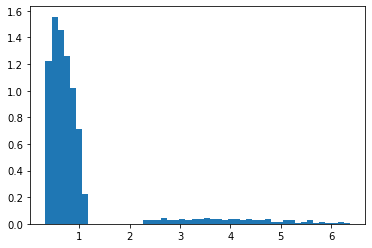

In [124]:
np.random.seed(32)

alpha, nCols, nFact, q = .995, 1000, 100, 10
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=N)
cov = np.cov(np.random.normal(size=(nCols*q, nCols)), rowvar=0) #size = (1000*10,1000)
cov = alpha*cov+(1-alpha)*getRndCov(nCols, nFact) # noise + signal
corr0 = cov2corr(cov)
eVal01, eVec01 = getPCA(corr0)
#pdf2 = fitKDE(np.diag(eVal01), bWidth=.15) #empirical pdf

    # Figure 2.1 Plot empirical:KDE and Marcenko-Pastur, and histogram
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.hist(np.diag(eVal01), density = True, bins=50) # Histogram the eigenvalues

In [125]:
# find expected max eigenvalue and variance that maximizes the distance
eMax0, var0 = findMaxEval(np.diag(eVal01), q, bWidth=.01)

sse:743.4008496632008
sse:743.4007571174983
sse:289.4622295747722
sse:289.4622254285054
sse:280.2675575669025
sse:280.2675620059499
sse:229.6079210181446
sse:229.60792858384144
sse:371.5543557712253
sse:371.5542965282732
sse:64.68529622202144
sse:64.68530786186403
sse:18.8776557465043
sse:18.877657749558164
sse:2675.5102605016846
sse:2675.5099844325546
sse:20.62065641088067
sse:20.620652019267865
sse:18.31293327607392
sse:18.31293331529114
sse:18.31272833100626
sse:18.312728329380647
sse:18.312727977747382
sse:18.31272797774865
sse:18.312727977747947
sse:18.312727977747826
sse:18.31272797774743
sse:18.312727977748537
sse:18.312727977747414
sse:18.312727977748665
sse:18.31272797774746
sse:18.312727977748622
sse:18.312727977747382
sse:18.31272797774865
sse:18.312727977747496
sse:18.31272797774862
sse:18.312727977747382
sse:18.31272797774865
sse:18.312727977747496
sse:18.31272797774862
sse:18.312727977747382
sse:18.31272797774865
sse:18.312727977747496
sse:18.31272797774862
sse:18.3127279

**The fitted distribution implies that σ² ≈ 0.6768, indicating that only about 32.32% of the variance is signal. This is one way of measuring the signal-to-noise ratio in financial data sets, which is known to be low as a result of arbitrage forces.**


In [137]:
var0

0.6762118250800502

In [126]:
# calculate the number of factors (nFacts0) that have eigenvalues greater than a specified threshold (eMax0)nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)
nFacts0 = eVal01.shape[0]-np.diag(eVal01)[::-1].searchsorted(eMax0)




In [133]:
len(eVal01)

1000

In [139]:
pdf0 = mpPDF(var0, q=x.shape[0]/float(x.shape[1]), pts=N)

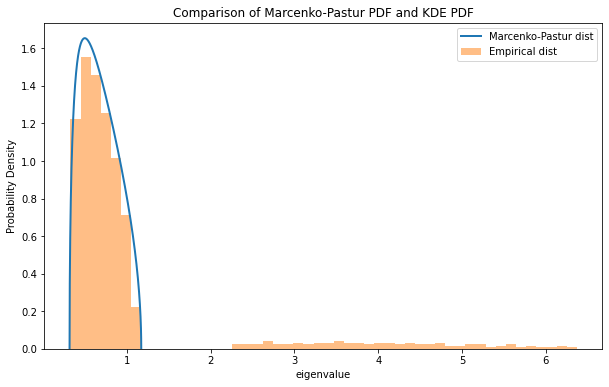

In [143]:
plt.figure(figsize=(10, 6))
plt.plot(pdf0.keys(), pdf0, label='Marcenko-Pastur dist', linewidth=2)
plt.hist(np.diag(eVal01), bins=50, density=True, alpha=0.5, label='Empirical dist')

#plt.plot(pdf1.keys(), pdf1, label='KDE PDF', linestyle='--', linewidth=2)
plt.title('Comparison of Marcenko-Pastur PDF and KDE PDF')
plt.xlabel('eigenvalue')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [141]:
eVal01

array([[6.36977896, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.24221779, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 6.15020581, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33268001, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.32911829,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.3264524 ]])